## Imports & constants

In [1]:
import os
from copy import copy
from itertools import chain
from collections import defaultdict
from functools import partial
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats

# plotting and visuals
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scikitplot as skplt
import logomaker
from tqdm import tqdm
from IPython.display import display
theme_bw = 'theme_bw.mplstyle'
plt.style.use(theme_bw)

# preprocessing, visualization & model selection
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold


# models
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


OUR = 'Shomuradova et al.'
PAPER = 'Shoukat et al.'
ALPHA = 0.05

Matplotlib is building the font cache; this may take a moment.


## Matrix generation

#### Dataframes from tables for format inspection 

In [45]:
our_test_df

,count,freq,cdr3nt,cdr3aa,v,d,j,VEnd,DStart,DEnd,JStart
0,3235,0.049892,TGTGCCAGCAGCGCCCCAGCGGGGGTCGGCGAGCAGTACTTC,CASSAPAGVGEQYF,TRBV7-9,TRBD2,TRBJ2-7,11,17,22,29
1,2410,0.037168,TGTGCCAGCAGCCCAAGGGCAGGGAAGGGTGAGCAGTTCTTC,CASSPRAGKGEQFF,TRBV7-9,TRBD1,TRBJ2-1,11,19,23,29
2,1794,0.027668,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF,TRBV12-3,TRBD1,TRBJ2-7,13,16,20,22
3,1023,0.015777,TGTGCCAGCAGCCAATGGGGGGGTACGCCCTACGAGCAGTACTTC,CASSQWGGTPYEQYF,TRBV27,TRBD1,TRBJ2-7,10,16,20,28
4,1002,0.015453,TGTGCCAGCAGCCCGCCGGGACAGCACAATGAGCAGTTCTTC,CASSPPGQHNEQFF,TRBV5-6,TRBD1,TRBJ2-1,11,15,23,25
...,...,...,...,...,...,...,...,...,...,...,...
31613,1,0.000015,TGCAGTGACGGCTACACCTTC,CSDGYTF,TRBV20-1,.,TRBJ1-2,6,-1,-1,9
31614,1,0.000015,TGTGCTGTGCAGTATTTT,CAVQYF,TRBV7-7,.,TRBJ2-3,4,-1,-1,8
31615,1,0.000015,TGTGCCGAGCAGTACTTC,CAEQYF,TRBV15,.,TRBJ2-7,5,-1,-1,5
31616,1,0.000015,TGCAGTGCTAGCGCC,CSASA,TRBV20-1,.,TRBJ2-1,10,-1,-1,14


In [44]:
our_test_df = pd.read_csv('convalescent/down.1434.TRB.txt', sep='\t')
paper_test_df = pd.read_csv('use_of_ml_paper_data/patient/Pt-11-1.clonotypes.TRB.txt.gz', sep='\t')

In [2]:
def reformat_table(df):
    """
    Переименовывает поля в соответствии с форматом Shomuradova et al.
    """
    cols = ['allVHitsWithScore', 'allDHitsWithScore', 'allJHitsWithScore']
    for col in cols:
        df[col[3].lower()] = df[col].apply(lambda x: \
                                         x.split(',')[0].split('*')[0] if pd.notna(x) else x) 
    df.drop(columns=cols)
    df['freq'] = df['cloneFraction']
    df['count'] = df['cloneCount']
    df['cdr3aa'] = df['aaSeqCDR3']
    return df
    
    
def normalize_v_usage(df):
    unique_vgenes = np.unique(df['v'])
    for uq_vgene in unique_vgenes:
        total_freq = df.query('v == @uq_vgene')['freq'].sum()
        df['freq'] = np.where(df['v'] == uq_vgene, df['freq'] / total_freq, df['freq'])
    df['freq'] = df['freq'] / df['freq'].sum()
    return df
        
        
def find_kmers(seq, k):
    """
    Генерирует к-меры по строке seq
    """
    seq = seq.replace('_', '').replace('*', '')
    for i in range(0, len(seq) - k + 1):
        yield i, seq[i:i+k]

def count_segments(df, total_fraction=1):
    results = {letter: defaultdict(int) for letter in 'vdj'}
    
    cumulative_fraction = 0
    for i, clone in df.iterrows():
        for letter in 'vdj':
            segment_id = clone[letter]
            if pd.notna(segment_id) and segment_id != '.':
                results[letter][segment_id] += clone['freq']
        cumulative_fraction += clone['freq']
        # if cumulative_fraction > total_fraction:
        #     break
    return results

def count_kmers(df, k=3, most_common=300, total_fraction=1):
    tmp = defaultdict(int)
    cumulative_fraction = 0
    for i, clone in df.iterrows():
        seq = clone['cdr3aa'].replace('_', '').replace('*', '')
        for _, kmer in find_kmers(seq, k):
            tmp[kmer] += clone['freq']
        cumulative_fraction += clone['freq']
        # if cumulative_fraction > total_fraction:
        #     break
            
    results = defaultdict(int)     
    results.update(dict(sorted(tmp.items(), key=lambda x: -x[1])[:most_common]))
    return results

def read_folder(folder, source, group, k=3, most_common_kmers=300, total_fraction=1,
               v_gene_normalize=False):
    
    if not folder.endswith('/'):
        folder += '/'
    list_of_records = []
    for i, filename in tqdm(enumerate(os.listdir(folder))):
        
        df = pd.read_csv(folder + filename, sep='\t')
        
        if source == 'paper':
            df = reformat_table(df)
            
        if v_gene_normalize:
            df = normalize_v_usage(df)
            
        df = df[['count', 'freq', 'cdr3aa', 'v', 'd', 'j']]
        
        segments = count_segments(df, total_fraction=total_fraction)
        record = count_kmers(df, k=k, most_common=most_common_kmers, 
                             total_fraction=total_fraction)
        
        for segment_letter, segment_id_counts in segments.items():
            record.update(segment_id_counts)
        
        record['id'] = source[0] + group[0] + str(i)
        record['source_short'] = source
        record['source'] = 'Shomuradova et al.' if source == 'our' else 'Shoukat et al.'
        if group == 'Healthy':
            record['label'] = 0
        else:
            record['label'] = 1
        
        list_of_records.append(record)
        
    df = pd.DataFrame(list_of_records)
    df.set_index('id', inplace=True)
    return df

In [189]:
normalize_flag = True
k = 3

our_healthy = read_folder('healthy/', 'our', 'Healthy', k=k, 
                         v_gene_normalize=normalize_flag)
our_patients = read_folder('convalescent/', 'our', 'Patient', k=k, 
                        v_gene_normalize=normalize_flag)
paper_patients = read_folder('use_of_ml_paper_data/patient/', 'paper', 'Patient', k=k, 
                           v_gene_normalize=normalize_flag)
paper_healthy = read_folder('use_of_ml_paper_data/healthy/', 'paper', 'Healthy', k=k, 
                           v_gene_normalize=normalize_flag)

14it [02:27, 10.52s/it]
20it [04:11, 12.57s/it]
6it [00:30,  4.66s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
9it [00:46,  4.91s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
19it [01:31,  4.81s/it]
38it [01:22,  2.16s/it]


In [190]:
all_data = pd.concat([our_healthy, our_patients, paper_healthy, paper_patients])
all_data.fillna(0, inplace=True)
# all_data.to_csv('all_data.csv')
# all_data.to_csv('all_data_normalized.csv')

#### Read not normalized data

In [47]:
# read not normalized data
all_data = pd.read_csv('all_data.csv').set_index('id')
all_data.head()

,CAS,ASS,QYF,QFF,EQF,EQY,NEQ,TQY,SSL,YEQ,...,TRE,PTR,YPG,RSA,DQD,HDQ,GHD,SVK,VKA,KAE
id,,,,,,,,,,,,,,,,,,,,,
oH0,0.711891,0.591714,0.399431,0.207780,0.204617,0.196711,0.196711,0.185009,0.180582,0.141366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH1,0.768340,0.661250,0.464170,0.145330,0.142310,0.189710,0.118720,0.247560,0.178210,0.143060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH2,0.752164,0.656325,0.337528,0.211051,0.206417,0.090207,0.163840,0.248479,0.192353,0.074727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH3,0.671180,0.592070,0.501970,0.239060,0.235430,0.263000,0.186740,0.199890,0.127060,0.158050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH4,0.783810,0.653740,0.357340,0.184040,0.180520,0.158180,0.146140,0.170920,0.200560,0.117340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Read normalized data

In [4]:
# read normalized data
all_data = pd.read_csv('all_data_normalized.csv').set_index('id')
all_data.head()

,CAS,ASS,QYF,QFF,EQF,TQY,EQY,NEQ,SSL,AFF,...,SGH,SQQ,HSN,QQD,PAV,YLP,RKQ,YRK,TRP,LRL
id,,,,,,,,,,,,,,,,,,,,,
oH0,0.813133,0.690551,0.376896,0.197163,0.194394,0.185249,0.177439,0.174113,0.167291,0.143962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH1,0.812842,0.670046,0.454569,0.153304,0.150735,0.241017,0.193028,0.133003,0.149307,0.080083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH2,0.820834,0.678862,0.312522,0.212372,0.190789,0.242717,0.089012,0.153251,0.182180,0.112194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH3,0.813622,0.685361,0.491680,0.231319,0.228573,0.221450,0.217000,0.181420,0.161943,0.052729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oH4,0.810688,0.649260,0.373931,0.179032,0.175871,0.183169,0.169808,0.158639,0.145777,0.119536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Selecting subsets of the data

In [6]:
j_segment_labels = [col for col in all_data.columns if col.startswith('TRBJ')]
v_segment_labels = [col for col in all_data.columns if col.startswith('TRBV')]
d_segment_labels = [col for col in all_data.columns if col.startswith('TRBD')]
all_segment_labels = [col for col in all_data.columns if col.startswith('TRB')]

source_labels =['source', 'source_short']

kmer_labels = set(all_data.columns) - set(v_segment_labels) - set(j_segment_labels) - \
    set(d_segment_labels) - set(source_labels) - set(['label'])

In [7]:
df = all_data.copy() #[v_segment_labels + ['source', 'label']]
# df = all_data.drop(columns=v_segment_labels).copy() # no v gene segments
#df = all_data.drop(columns=all_segment_labels)  # only kmers
# df = all_data.drop(columns=j_segment_labels + d_segment_labels)
# df = all_data[v_segment_labels+ source_labels + j_segment_labels + ['label']]  # v  + j
# df = all_data[ j_segment_labels + source_labels + ['label']]  # only j
# df = all_data.drop(columns=v_segment_labels + d_segment_labels)
# df = all_data.drop(columns=j_segment_labels + d_segment_labels)

our_data = df.query('source_short == "our"')
paper_data = df.query('source_short == "paper"')

X = df.drop(columns=['source', 'label', 'source_short']).to_numpy()
y = df['label'].to_numpy()

our_X = our_data.drop(columns=['source', 'label', 'source_short']).to_numpy()
our_y = our_data['label'].to_numpy()

paper_X = paper_data.drop(columns=['source', 'label', 'source_short']).to_numpy()
paper_y = paper_data['label'].to_numpy()

#### Scaling

In [101]:
sc = StandardScaler()
# sc = RobustScaler()
# sc = MinMaxScaler()

X_scaled = sc.fit_transform(X)
our_X_scaled = sc.fit_transform(our_X)
paper_X_scaled = sc.fit_transform(paper_X)

## Data visualization

### PCA

#### Explained variance

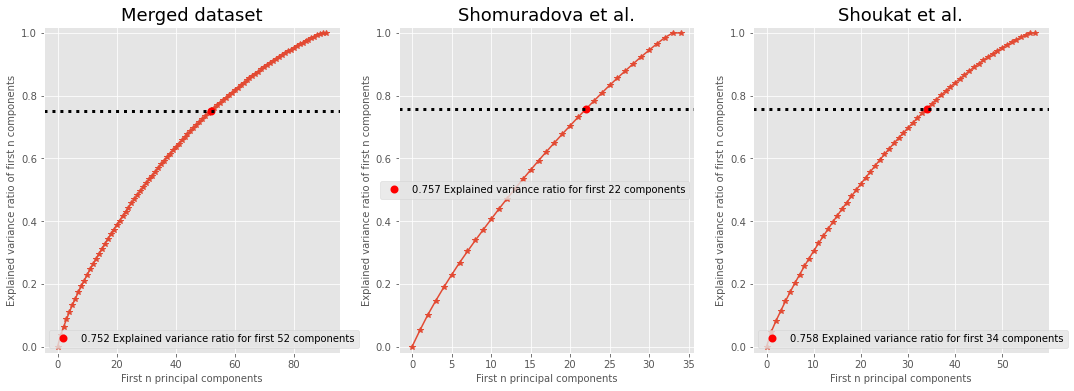

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

pca = PCA()

for dataset, title, ax in zip([X_scaled, our_X_scaled, paper_X_scaled], ['Merged dataset', OUR, PAPER], axs):
    pca.fit(dataset)
    skplt.decomposition.plot_pca_component_variance(pca, ax=ax)
    ax.set_title(title, fontsize=18)

#### Joint Plots

In [108]:
def drop_outliers(X, y, source=None, n_max=1):
    cols = ['PC1', 'PC2']
    tmp = pd.DataFrame(X, columns=cols)
    tmp['label'] = y
    if source is None:
        pass
    else:
        tmp['source'] = source
    for col in cols:
        max_value = tmp[col].max()
        tmp = tmp[tmp[col] != max_value]
    if source is None:
        return tmp[cols].to_numpy(), tmp['label'] 
    else:
        return tmp[cols].to_numpy(), tmp['label'], tmp['source']
    # display(tmp.head())
    # sns.scatterplot(x='PC1', y='PC2', data=tmp)
    # pass

# drop_outliers(X_pca_first2, paper_y)

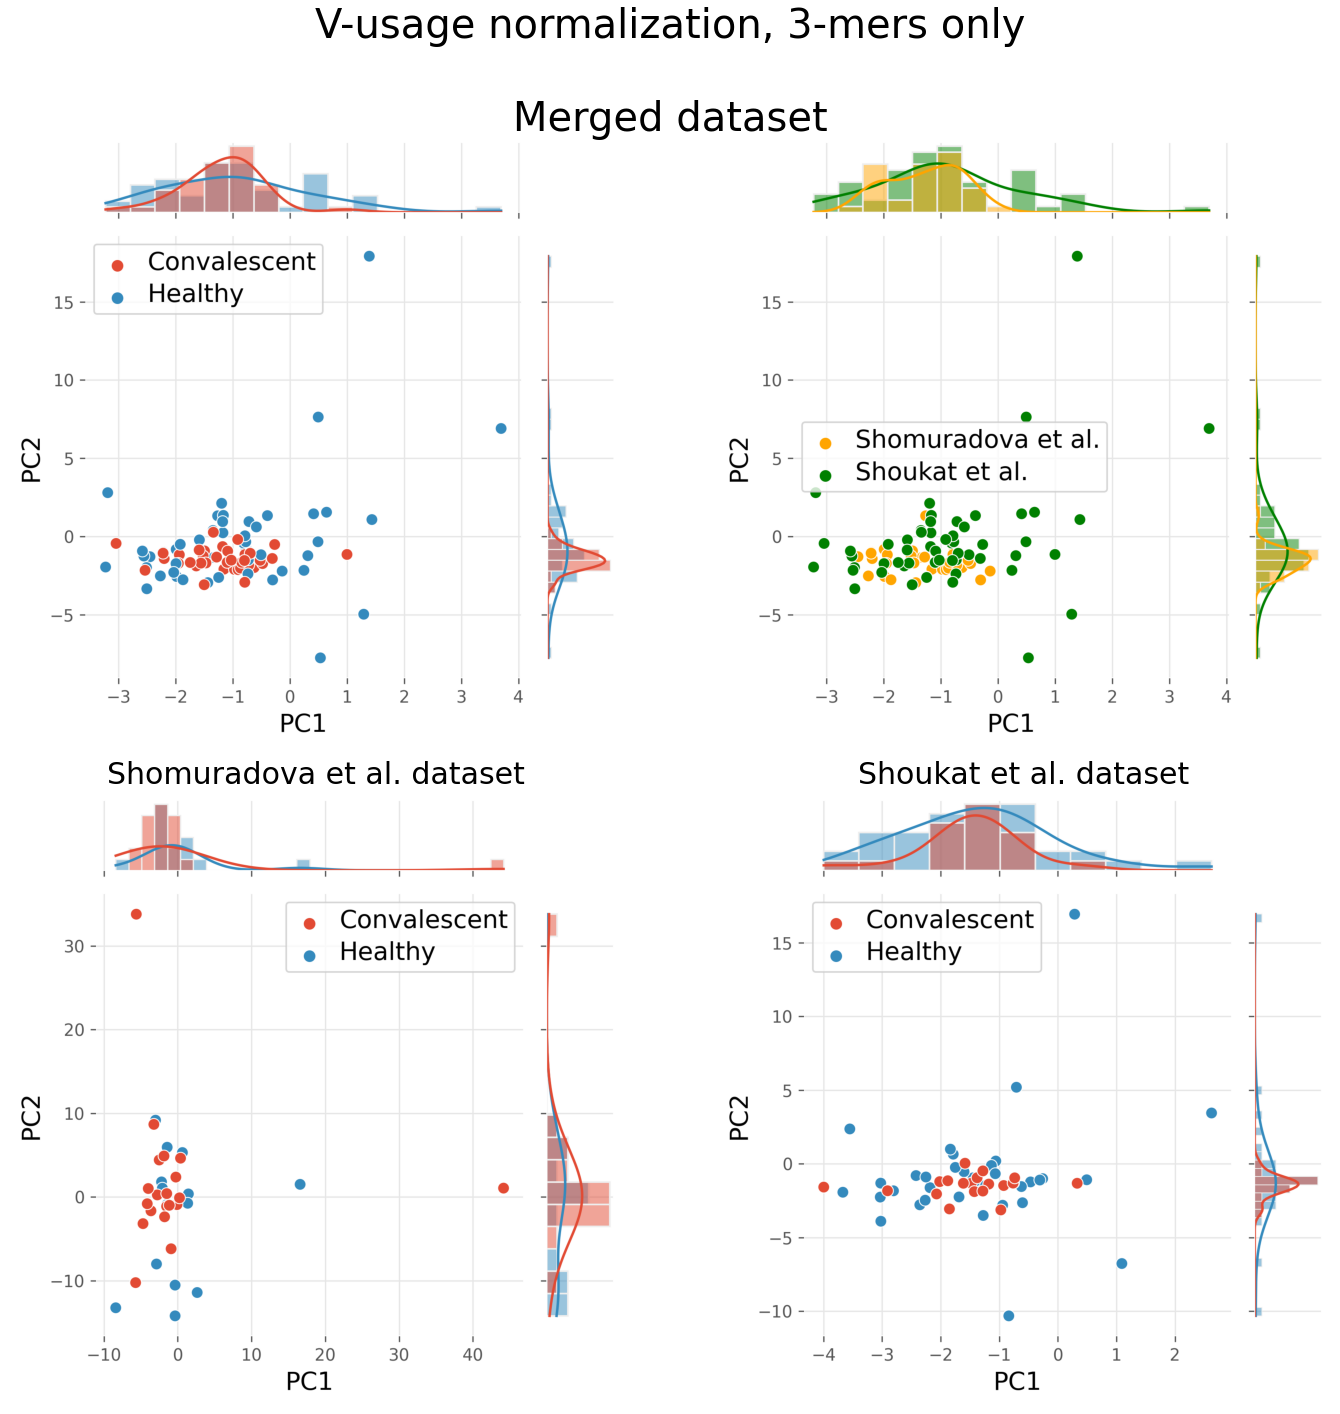

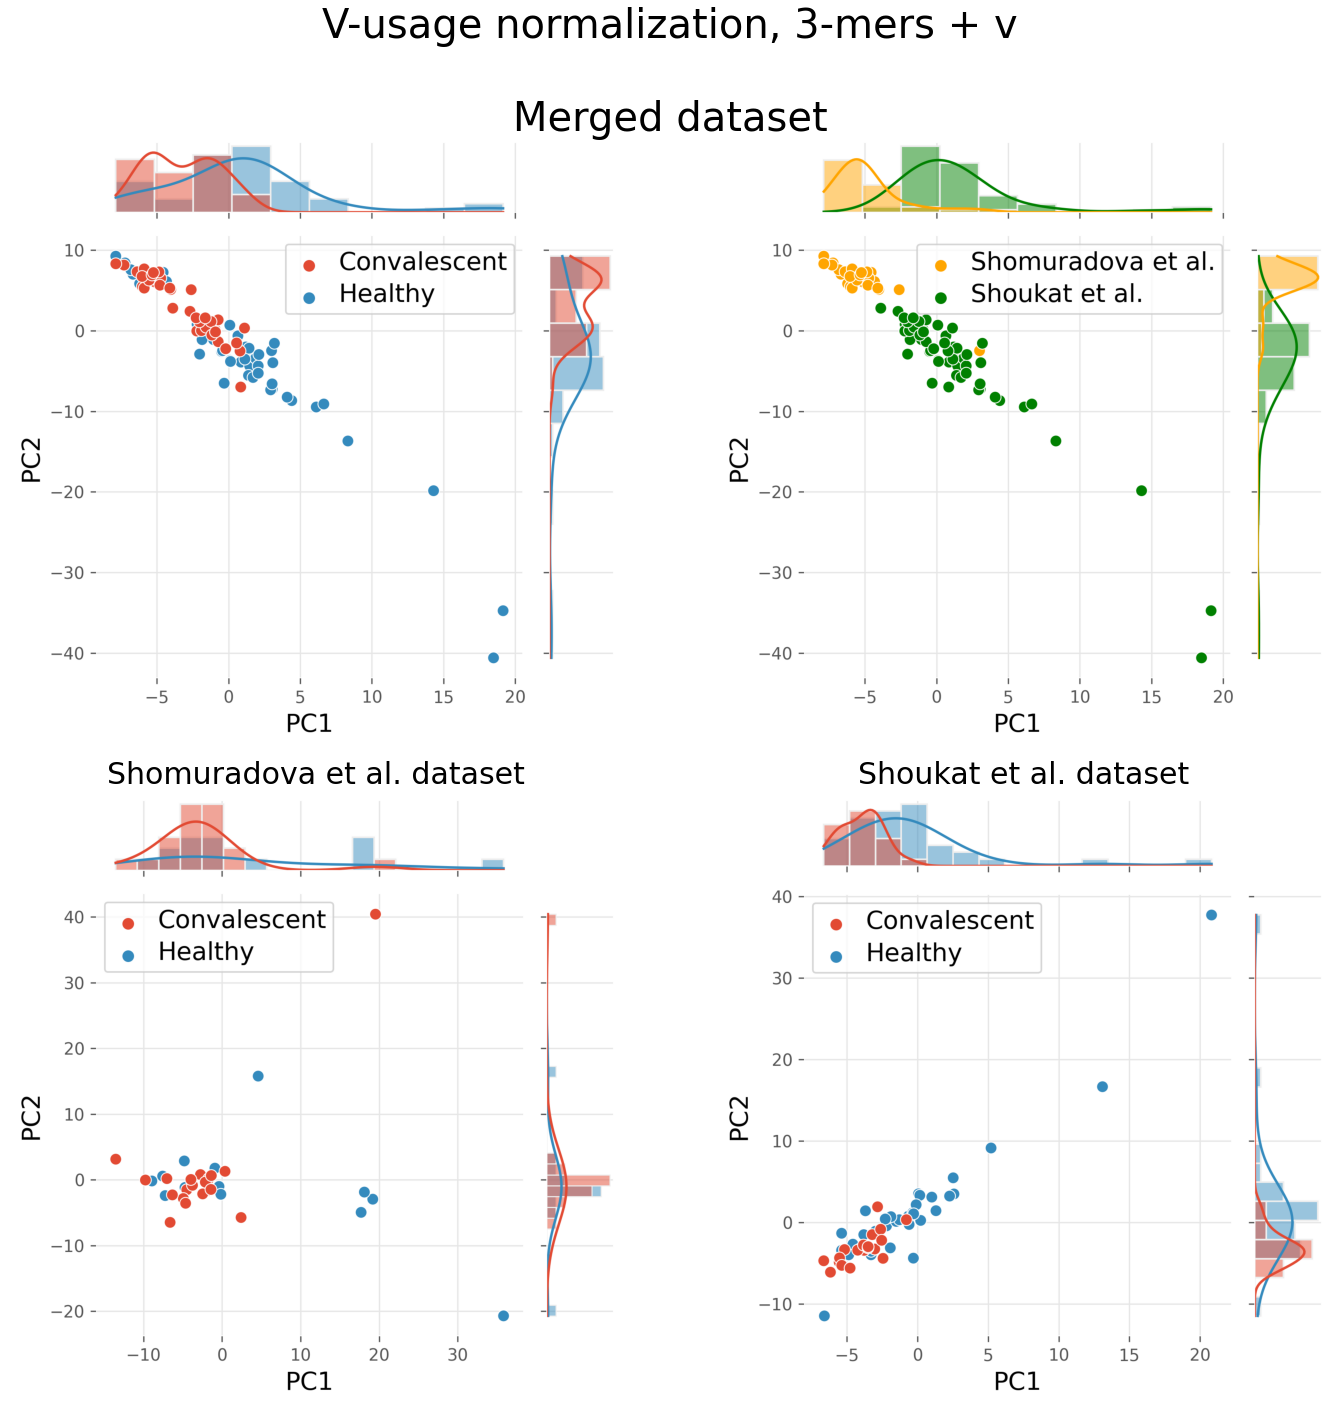

In [109]:
def make_plots(suptitle='', features='3-mers only', dpi=300):
    if features == '3-mers only':
        X_all = all_data[kmer_labels].to_numpy()
        X_our = our_data[kmer_labels].to_numpy()
        X_paper = paper_data[kmer_labels].to_numpy()
    else:
        X_all = all_data[list(kmer_labels) + v_segment_labels].to_numpy()
        X_our = our_data[list(kmer_labels) + v_segment_labels].to_numpy()
        X_paper = paper_data[list(kmer_labels) + v_segment_labels].to_numpy()
    
    def decode_target_labels(y):
        return np.where(y, 'Convalescent', 'Healthy')
    
    y = decode_target_labels(all_data['label'])
        
    X_all = StandardScaler().fit_transform(X_all)
    X_all = PCA(n_components=2).fit_transform(X_all)
    X_all, y, source = drop_outliers(X_all, y, all_data['source'].to_numpy())
    
    def make_jg(X, hue, hue_order, palette=None):
        jp = sns.JointGrid(x=X[:, 0], y=X[:, 1], hue=hue, height=5, 
                          hue_order=hue_order, palette=palette) #palette=['red', 'blue'])

        jp.plot_joint(sns.scatterplot, s=50, )
        jp.plot_marginals(sns.histplot, kde=True)

        jp.fig.tight_layout()

        jp.ax_joint.set_xlabel("PC1", fontsize=15);
        jp.ax_joint.set_ylabel('PC2', fontsize=15);

        leg = jp.ax_joint.get_legend()
        leg.set_title('')
        for text in leg.texts:
            text.set_fontsize(15)
        return jp
    
    jp1 = make_jg(X_all, hue=y, hue_order=['Convalescent', 'Healthy'])
    jp2 = make_jg(X_all, hue=source, hue_order=[OUR, PAPER], palette=['orange', 'green'])
    plt.close(jp1.fig)
    plt.close(jp2.fig)
    jp1.savefig('jp1.png', dpi=dpi)
    jp2.savefig('jp2.png', dpi=dpi)
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    axs[0, 0].imshow(mpimg.imread('jp1.png'))
    axs[0, 1].imshow(mpimg.imread('jp2.png'))
    
    datasets = [
        (X_our, our_data['label'], OUR),
        (X_paper, paper_data['label'], PAPER)
    ]
    for i, (X, y, dataset_source) in enumerate(datasets):
        y = decode_target_labels(y)
        X = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))
        if dataset_source == PAPER:
            X, y = drop_outliers(X, y)
        jp = make_jg(X, hue=y, hue_order=['Convalescent', 'Healthy'])
        plt.close(jp.fig)
        jp.savefig('jp.png', dpi=dpi)
        axs[1][i].imshow(mpimg.imread('jp.png'))
        axs[1][i].set_title(dataset_source + ' dataset', fontsize=30)
        
    for ax in axs.reshape(-1):
        ax.set_axis_off()
    
    fig.suptitle(f'{suptitle}, {features}\n\nMerged dataset', fontsize=40)
    fig.tight_layout()
        # ax.grid()
    # plt.close(jp2.fig)
    # j
    # jp1.fig.add_subfigure(make_jg(X, hue=source, hue_order=[OUR, PAPER]).fig)
    # make_jg(X, hue=data['source'])

suptitle = 'V-usage normalization'
make_plots(suptitle=suptitle)
make_plots(suptitle=suptitle, features='3-mers + v')

In [10]:
X_scaled = sc.fit_transform(X)

pca = PCA(n_components=2)
X_pca_first2 = pca.fit_transform(X_scaled)

tmp  = pd.DataFrame(X_pca_first2)
max0 =tmp[0].max()
max1 = tmp[1].max()
tmp.columns = ['pc1', 'pc2']
tmp = tmp.query('pc1 != @max0')
tmp = tmp.query('pc2 != @max1')
X_pca_first2 = tmp 

X_pca_first2['label'] = y[tmp.index]


# fig, ax = plt.subplots(figsize=(10, 8))
label = np.where(X_pca_first2['label'] == 1, 'Convalescent', 'Healthy')

# jp = sns.JointGrid(data=X_pca_first2, x='pc1', y='pc2', hue=label, height=10,palette=['blue', 'red'])
jp = sns.JointGrid(data=X_pca_first2, x='pc1', y='pc2', hue=label, height=10, 
                  hue_order=['Convalescent', 'Healthy'], ) #palette=['red', 'blue'])
jp.plot_joint(sns.scatterplot, s=100)
jp.plot_marginals(sns.histplot, kde=True)
# jp.plot_marginals(sns.kdeplot)
jp.fig.suptitle('Merged dataset; not normalized; 3-mers only', fontsize=30)
jp.fig.tight_layout()

jp.ax_joint.set_xlabel("PC1", fontsize=25);
jp.ax_joint.set_ylabel('PC2', fontsize=25);

leg = jp.ax_joint.get_legend()
for text in leg.texts:
    text.set_fontsize(20)

NameError: name 'sc' is not defined

In [73]:
jp.ax_joint.legend(fontsize=20)

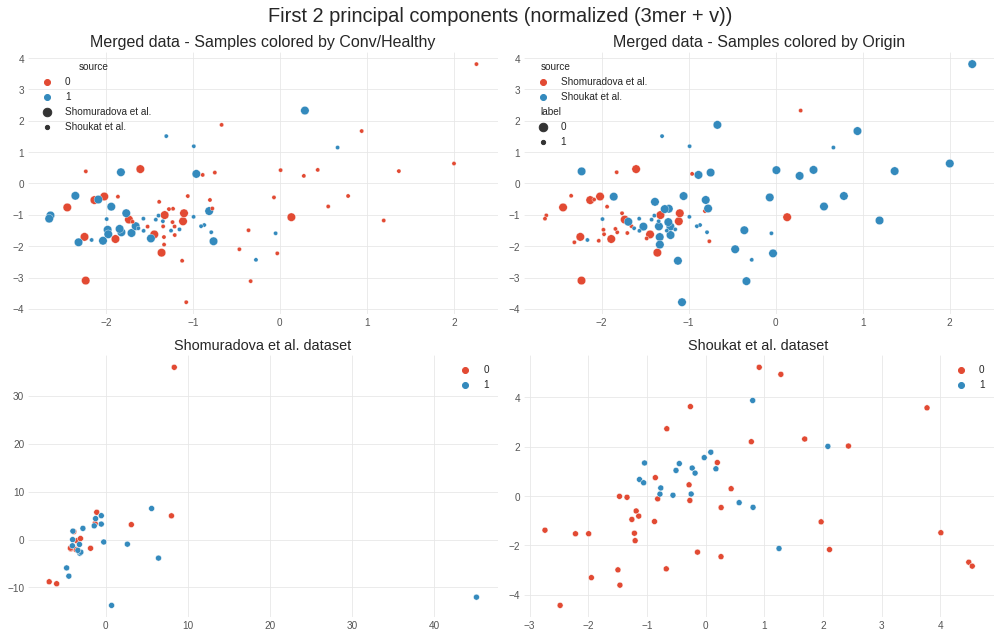

In [33]:
def plot_first_2_pc(title, scaled=False):
    pca = PCA(n_components=2)
    
    if scaled:
        X_pca_first2 = pca.fit_transform(X_scaled)
        our_X_pca_first2 = pca.fit_transform(our_X_scaled) 
        paper_X_pca_first2 = pca.transform(paper_X_scaled) 
    else:
        X_pca_first2 = pca.fit_transform(X)
        our_X_pca_first2 = pca.fit_transform(our_X) 
        paper_X_pca_first2 = pca.transform(paper_X)
    
    # remove outliers 
    tmp  = pd.DataFrame(X_pca_first2)
    max0 =tmp[0].max()
    max1 = tmp[1].max()
    tmp.columns = ['pc1', 'pc2']
    tmp = tmp.query('pc1 != @max0')
    tmp = tmp.query('pc2 != @max1')
    X_pca_first2 = tmp.to_numpy()    
    
        
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 9))
    sns.scatterplot(x=X_pca_first2[:, 0], y=X_pca_first2[:, 1], 
                    hue=df['label'].to_numpy()[tmp.index], ax=ax[0][0], 
                    size=df['source'][tmp.index])
    ax[0][0].set_title('Merged data - Samples colored by Conv/Healthy', fontsize=16)

    sns.scatterplot(x=X_pca_first2[:, 0], y=X_pca_first2[:, 1], hue=df['source'][tmp.index], ax=ax[0][1],
                   size=df['label'][tmp.index])
    ax[0][1].set_title('Merged data - Samples colored by Origin', fontsize=16)

    ax1 = ax[1]

    sns.scatterplot(x=our_X_pca_first2[:, 0], y=our_X_pca_first2[:, 1], hue=pd.Series(our_y), ax=ax1[0])
    ax1[0].set_title('Shomuradova et al. dataset')

    sns.scatterplot(x=paper_X_pca_first2[:, 0], y=paper_X_pca_first2[:, 1], hue=pd.Series(paper_y), ax=ax1[1])
    ax1[1].set_title('Shoukat et al. dataset')

    fig.suptitle(f'First 2 principal components ({title})' , fontsize=20)

    fig.tight_layout()

title = 'unnormalized (3mer + v)'
# title = 'unnormalized (3mer)' 
title = 'normalized (3mer)'
title = 'normalized (3mer + v)'
scale = True
plot_first_2_pc(title, scaled=scale)

#### PCA before and after normalization (plots for presentation)

In [ ]:
pca = PCA(n_components=2)
X_pca_first2_normalized = pca.fit_transform(X)

In [ ]:
X_pca_first2_not_normalized = pca.fit_transform(X)

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))

sns.scatterplot(x=X_pca_first2_not_normalized[:, 0], y=X_pca_first2_not_normalized[:, 1], ax=axs[0],
               hue=all_data['source'], s=150)
sns.scatterplot(x=X_pca_first2_normalized[:, 0], y=X_pca_first2_normalized[:, 1], ax=axs[1],
               hue=all_data['source'], s=150)

fig.suptitle('First 2 principal components in merged dataset', fontsize=35);

# axs[0].set_title('Before V-gene bias correction', fontsize=30)
# axs[1].set_title('After V-gene bias correction', fontsize=30)

for ax in axs:
    for text in ax.get_legend().get_texts():
        text.set_fontsize(25)
        
    ax.xaxis.label.set_text('PCA1')
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_text('PCA2')
    ax.yaxis.label.set_fontsize(20)
    ax.get_legend().get_title().set_text('')
    pass
fig.tight_layout()

### UMAP

In [203]:
paper_y.shape

(57,)

In [201]:
paper_X.shape

(57, 2453)

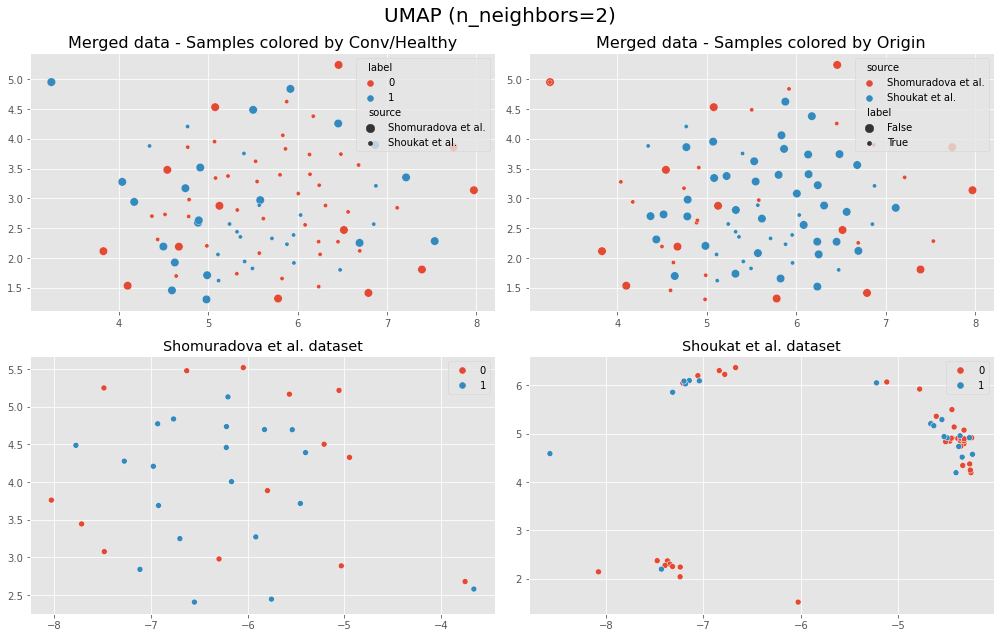

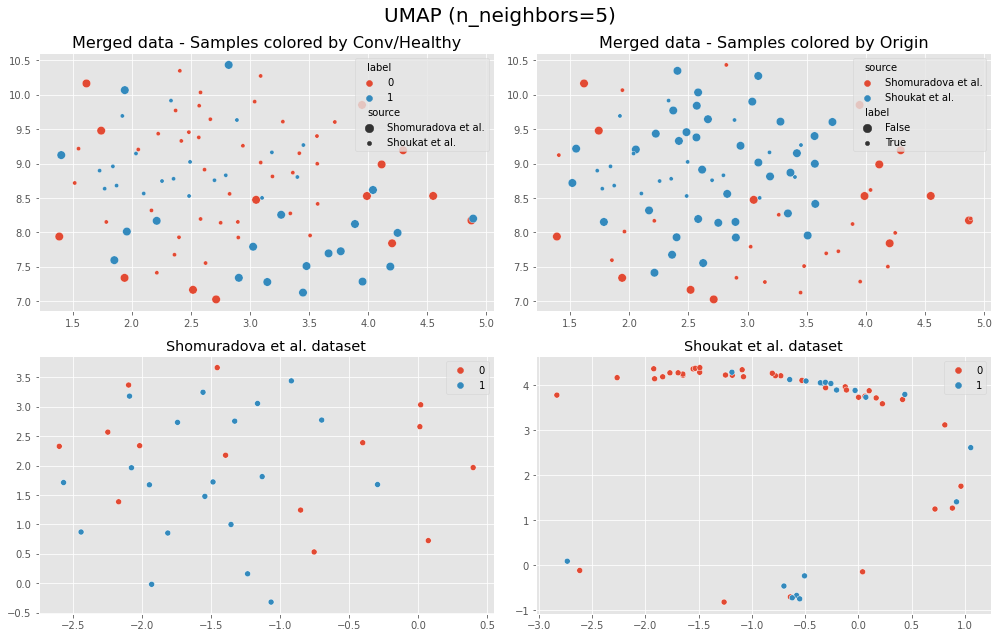

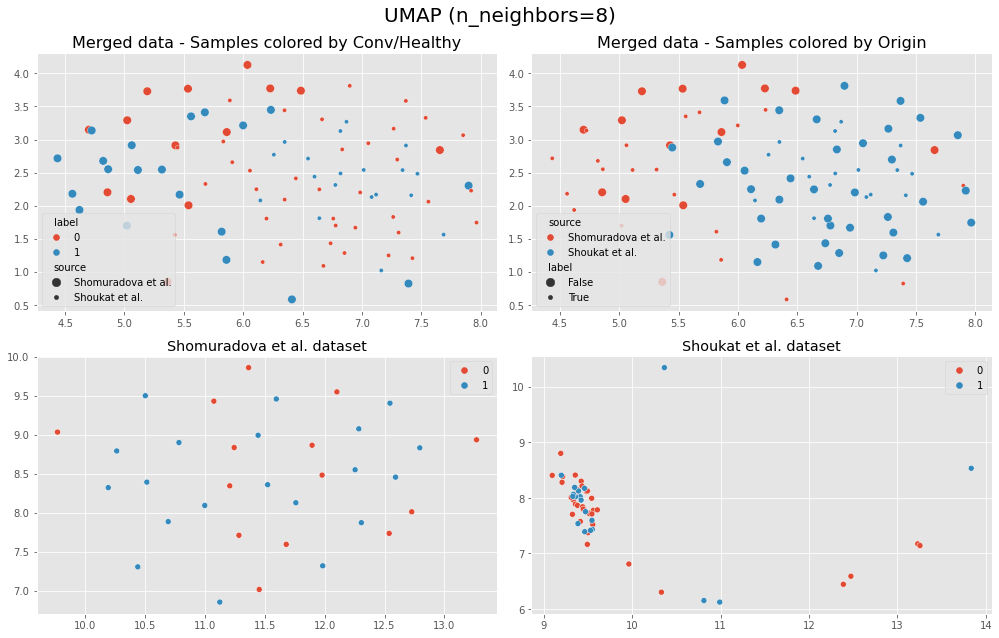

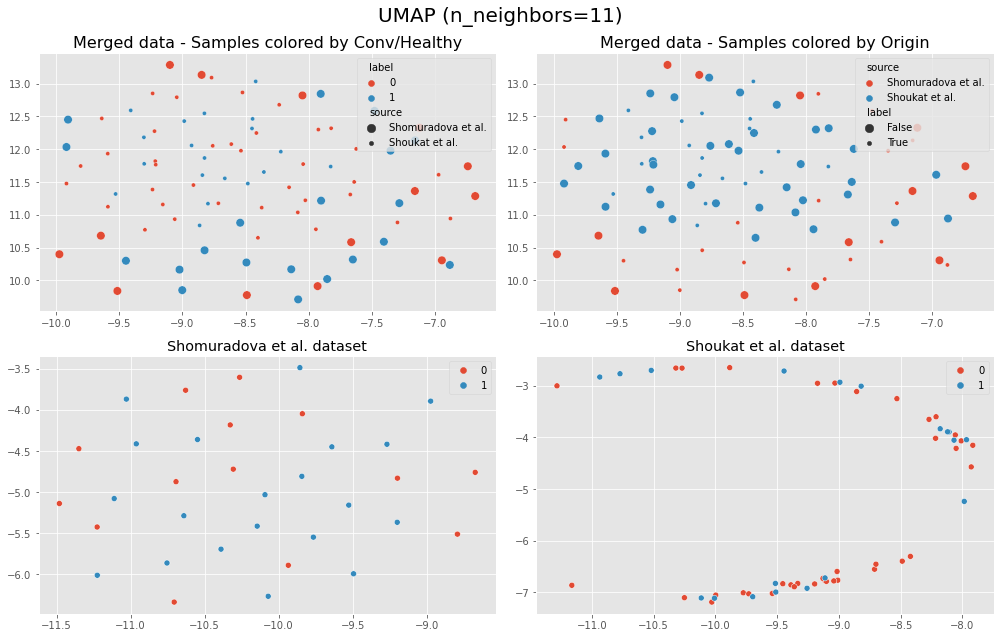

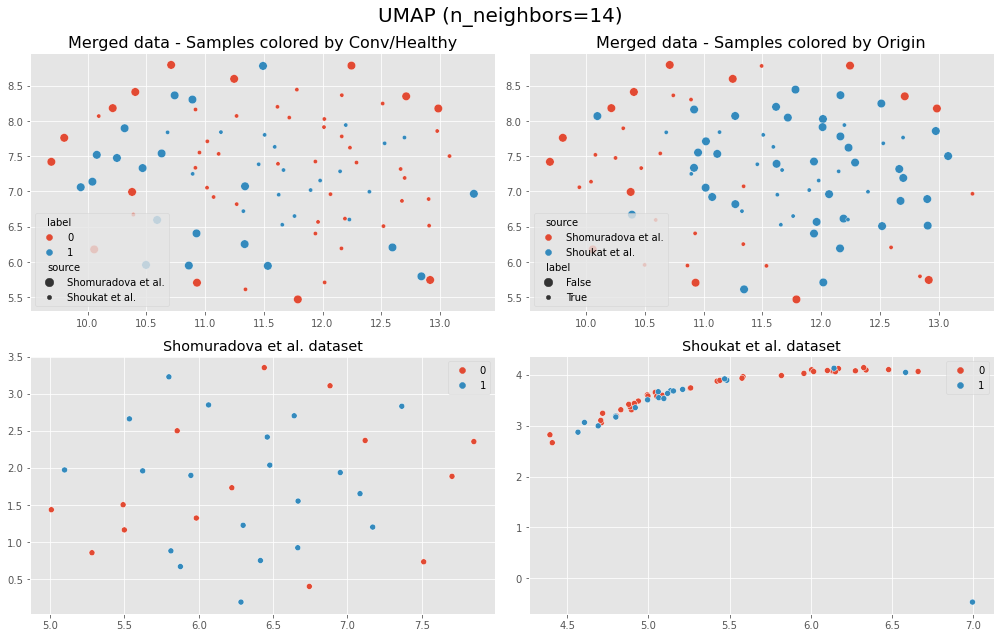

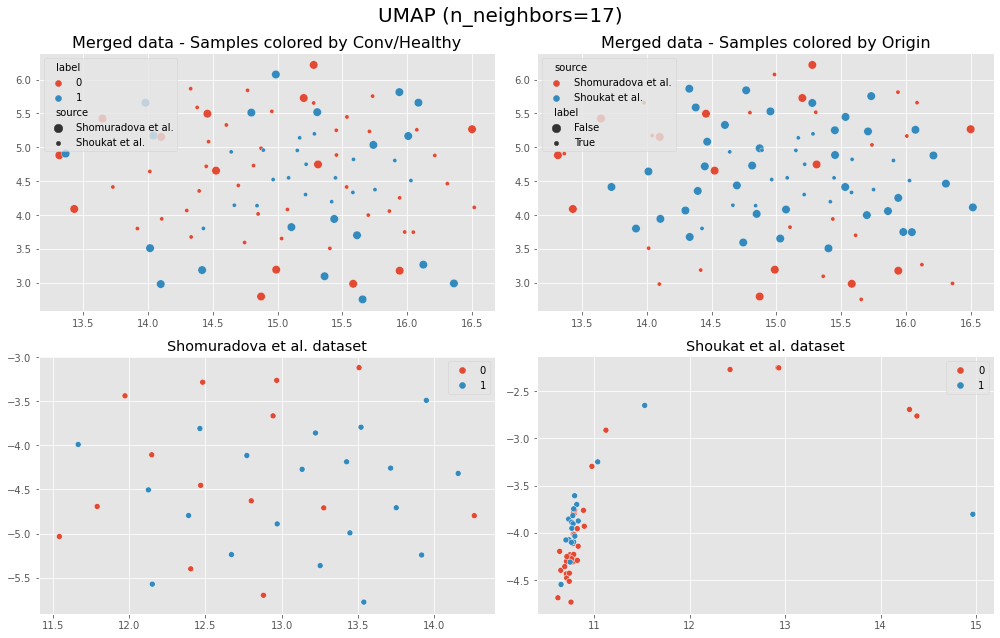

In [205]:
def draw_umap(n, scaled=False):
    reducer = umap.UMAP(random_state=28, n_neighbors=n, min_dist=0.0, metric='euclidean')
    
    if scaled:
        sc = StandardScaler()
        X_scaled = sc.fit_transform(X)
        our_X_scaled = sc.fit_transform(our_X)
        paper_X_scaled = sc.fit_transform(paper_X)
        
        X_mapped = reducer.fit_transform(X_scaled)
        our_X_mapped = reducer.fit_transform(our_X_scaled)
        paper_X_mapped = reducer.transform(paper_X_scaled)
    else:
        X_mapped = reducer.fit_transform(X)
        our_X_mapped = reducer.fit_transform(our_X)
        paper_X_mapped = reducer.transform(paper_X)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 9))
    sns.scatterplot(x=X_mapped[:, 0], y=X_mapped[:, 1], hue=df['label'], ax=ax[0][0], 
                    size=df['source'])
    ax[0][0].set_title('Merged data - Samples colored by Conv/Healthy', fontsize=16)
    
    sns.scatterplot(x=X_mapped[:, 0], y=X_mapped[:, 1], hue=df['source'], ax=ax[0][1],
                   size=df['label'] == 1)
    ax[0][1].set_title('Merged data - Samples colored by Origin', fontsize=16)
    
    ax1 = ax[1]
    
    sns.scatterplot(x=our_X_mapped[:, 0], y=our_X_mapped[:, 1], hue=pd.Series(our_y), ax=ax1[0])
    ax1[0].set_title('Shomuradova et al. dataset')
    
    sns.scatterplot(x=paper_X_mapped[:, 0], y=paper_X_mapped[:, 1], hue=pd.Series(paper_y), ax=ax1[1])
    ax1[1].set_title('Shoukat et al. dataset')
    
    fig.suptitle(f'UMAP (n_neighbors={i})', fontsize=20)
    
    fig.tight_layout()

scaled = True
n_values = list(range(2, 20, 3)) 
for i in n_values:
    draw_umap(i, scaled=scaled)

## Model`

#### CatBoost

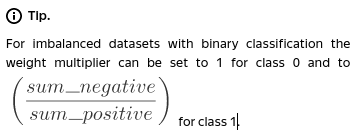

In [ ]:
sc = StandardScaler()
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

for i, title in zip(range(3), [our, paper, 'Merged (test_size=0.3)']):
    if i == 0:
        X_train, y_train = our_X, our_y
        X_test, y_test = paper_X, paper_y
    elif i == 1:
        X_train, y_train = paper_X, paper_y
        X_test, y_test = our_X, our_y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # pca = PCA(n_components=min(0, X_train.shape[0], X_train.shape[1]))
    pca = PCA()
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # weights = [1, np.sum(y_train == 0) / np.sum(y_train)]
    clf = CatBoostClassifier(verbose=False)
    # clf = CatBoostClassifier(verbose=False, class_weights=weights)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    print('Train dataset:', title, sep='\t')
    print('accuracy:', accuracy_score(y_test, y_pred), sep='\t')
    print('roc-auc:', roc_auc_score(y_test, y_pred), sep='\t')
    print('precision:', precision_score(y_test, y_pred), sep='\t')
    print('f1-score:', f1_score(y_test, y_pred), sep='\t')
    print('=' * 30)
    skplt.metrics.plot_roc(y_test, y_pred_prob, classes_to_plot=[1], figsize=(8, 6), ax=axs[i],
                          plot_macro=False, plot_micro=False);
    axs[i].set_title('Train dataset: ' + title, fontsize=20)
    for item in axs[i].get_legend().get_texts():
        item.set_fontsize(15)
    
fig.suptitle('CatBoost performance', fontsize=24)
fig.tight_layout();

#### Hierarchical clustering

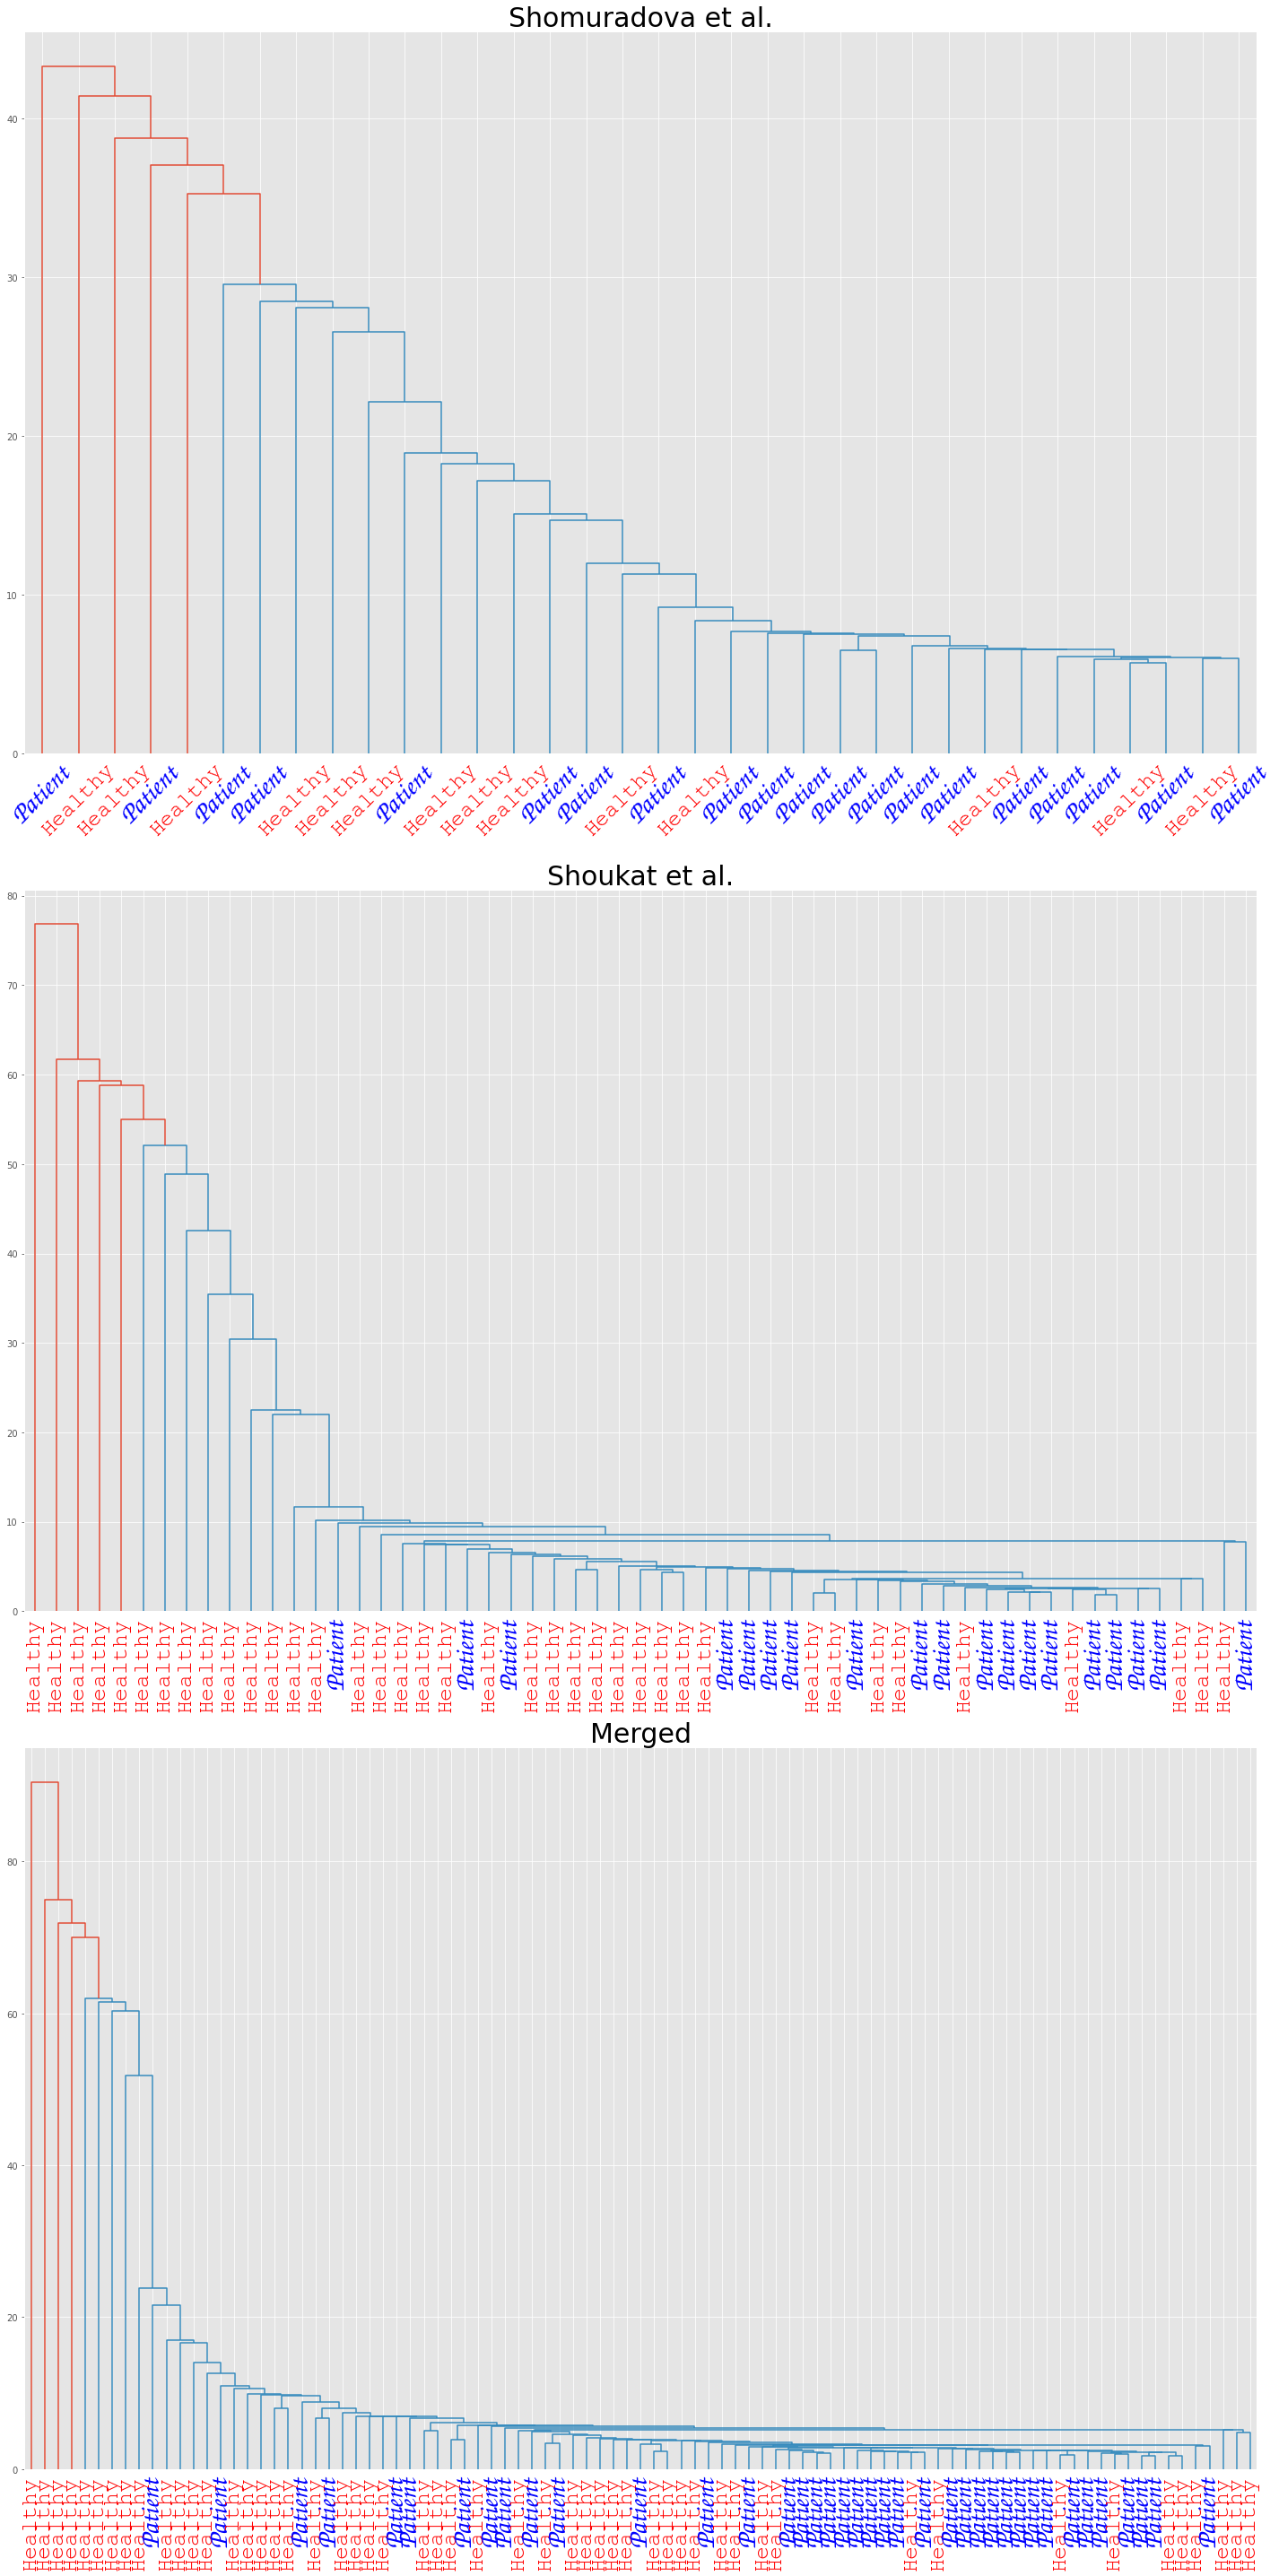

In [206]:
sc = StandardScaler()
ac = AgglomerativeClustering()
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 40))

def llf(k, true_labels):
    if true_labels[k] == 1:
        return 'Patient'
    return 'Healthy'

for i, title in zip(range(3), [OUR, PAPER, 'Merged']):
    if title == OUR:
        X_train, y_train = our_X.copy(), our_y.copy()
    elif title == PAPER:
        X_train, y_train = paper_X.copy(), paper_y.copy()
    else:
        X_train, y_train = X.copy(), y.copy()

    X_train = sc.fit_transform(X_train)
    
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    
    lnk = linkage(X_train,)
    
    axs[i].set_title(title, fontsize=30)
    _llf = partial(llf, true_labels=y_train)
    dendro = dendrogram(lnk, ax=axs[i], leaf_label_func=_llf,
                        leaf_font_size=20, show_leaf_counts=True, show_contracted=True, get_leaves=True)
    labels = axs[i].get_xmajorticklabels()
    for label in labels:
        if label.get_text() == 'Patient':
            label.set_color('blue')
            label.set_family('Z003')
            label.set_fontsize(30)
        else:
            label.set_color('red')
            label.set_family('Tlwg Typo')
            label.set_fontsize(25)
fig.tight_layout()

#####  Cluster by origin

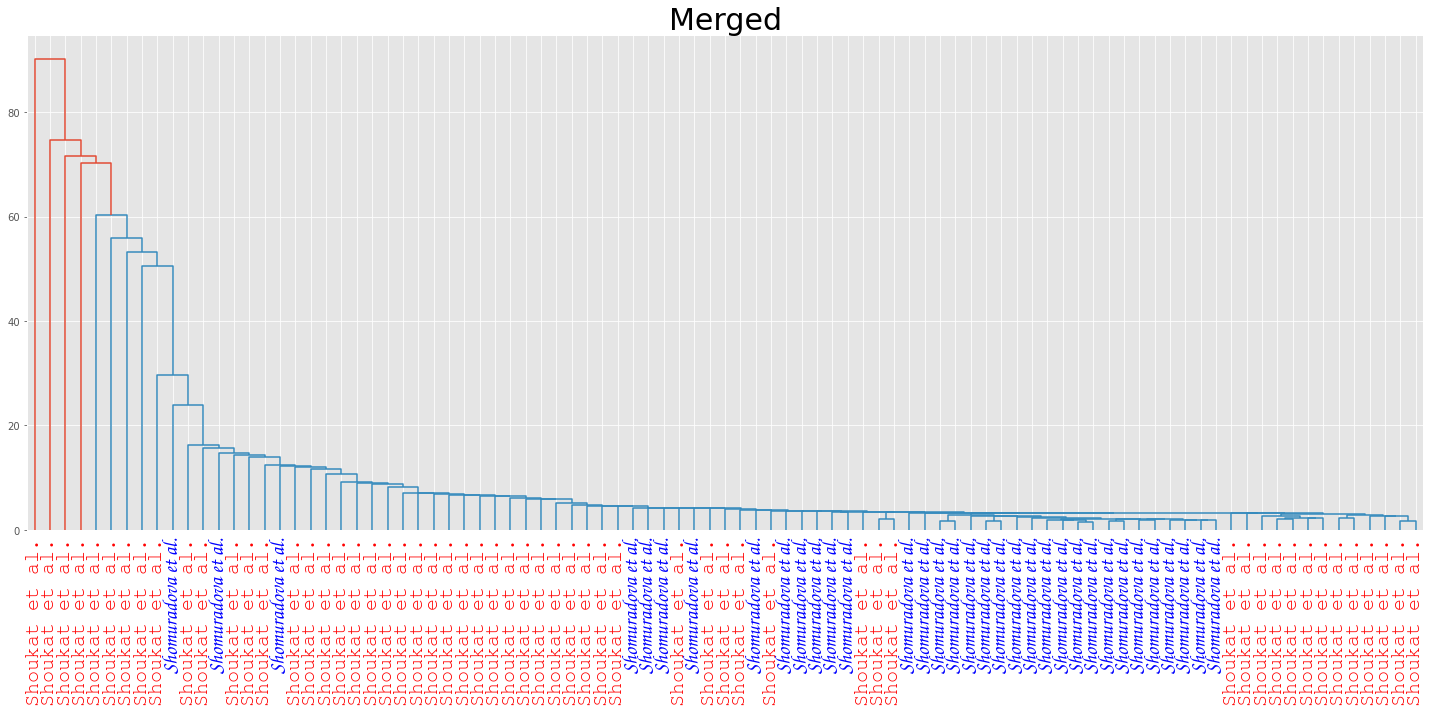

In [207]:
sc = StandardScaler()
ac = AgglomerativeClustering()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

def llf(k, true_labels):
    if true_labels[k] == 1:
        return OUR
    return PAPER

for i, title in zip(range(1), ['Merged']):
    if title == OUR:
        X_train, y_train = our_X.copy(), our_y.copy()
    elif title == PAPER:
        X_train, y_train = paper_X.copy(), paper_y.copy()
    else:
        X_train, y_train = X.copy(), y.copy()

    X_train = sc.fit_transform(X_train)
    
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    
    lnk = linkage(X_train,)
    
    true_labels = all_data['source_short'] == 'our'
    _llf = partial(llf, true_labels=true_labels)
    dendro = dendrogram(lnk, ax=axs, leaf_label_func=_llf,
                        leaf_font_size=20, show_leaf_counts=True, show_contracted=True, get_leaves=True)
    
    axs.set_title(title, fontsize=30)
    labels = axs.get_xmajorticklabels()
    for label in labels:
        if label.get_text() == OUR:
            label.set_color('blue')
            label.set_family('Z003')
            label.set_fontsize(20)
        else:
            label.set_color('red')
            label.set_family('Tlwg Typo')
            label.set_fontsize(20)
fig.tight_layout()

## Statistically significant k-mers

In [26]:
def find_ssk(df):
    total = 0
    results = []
    for kmer in tqdm(kmer_labels):
        tmp = df.loc[df[kmer] != 0, :]
        number_of_non_zero = tmp.shape[0]
        if number_of_non_zero > 30:
            total += 1

            healthy = tmp.query('label == 0')[kmer]
            conv = tmp.query('label == 1')[kmer]

            t, p = sp.stats.shapiro(np.log(tmp[kmer]))
            if p > 0.05:
                _, p = sp.stats.ttest_ind(healthy, conv)
            else:
                _, p = sp.stats.kruskal(healthy, conv)
            results.append([kmer, p])

    ssk_bonferroni = [] 
    ssk_noadj = []
    for i, (kmer, p) in enumerate(results):
        if p < ALPHA:
            ssk_noadj.append((kmer, p))
        if p < ALPHA / total:
            ssk_bonferroni.append((kmer, p))
    res = {
        'noadj': ssk_noadj,
        'bonf': ssk_bonferroni
    }
    return res

In [31]:
all_ssk = find_ssk(all_data)
our_ssk = find_ssk(our_data)
paper_ssk = find_ssk (paper_data)

100%|██████████| 2453/2453 [00:43<00:00, 56.83it/s]


NameError: name 'our_data' is not defined

In [9]:
print(OUR + ':', our_ssk, sep='\n')
print(PAPER + ':', paper_ssk, sep='\n')

Shomuradova et al.:
{'noadj': [('SLE', 0.036141840259017885), ('GTD', 0.03279734813468713), ('GGP', 0.04154141471548377), ('SSD', 0.014139197201630945), ('TSD', 0.03576733242200861)], 'bonf': []}
Shoukat et al.:
{'noadj': [('GGE', 0.008989874417828527), ('ISV', 0.003894102946279039), ('TDT', 0.018622389737396387), ('AGA', 0.04326628795699148), ('SYG', 0.042789461646657416), ('NQP', 0.0009336001319992702), ('YNE', 0.0014601888458007559), ('GGQ', 0.023231666414976797), ('DTG', 0.02640704903191411), ('GQE', 0.007660586373599153), ('PQH', 1.945159429928686e-05), ('YTF', 3.8160612307013635e-07), ('SSW', 0.036300169209178654), ('YGY', 3.023476330014292e-06), ('LHF', 0.029311432340328694), ('CIS', 0.002893459329467209), ('NTE', 0.003639647227611695), ('CSV', 0.020386975270027866), ('CAW', 0.02616778575025692), ('ANT', 0.020267983281617316), ('PLH', 0.03165995615779674), ('GST', 0.002442546854486755), ('NYG', 0.0021871554529953757), ('GGL', 0.01575419785932933), ('QHF', 1.9842761624294615e-05)

In [116]:
set(paper_ssk['noadj']).intersection(our_ssk['noadj'])

set()

In [120]:
tmp = set(paper_ssk['noadj'])
for k in our_ssk['noadj']:
    if k in tmp:
        print('hehey!')

Значимые кмеры не пересекаются...

Посмотрим на кмеры с самым низким значением $p$-значения:

In [23]:
best_kmers = sorted(paper_ssk['noadj'], key=lambda x: x[1])[:5]
best_kmers

[('YTF', 3.8160612307013635e-07),
 ('GYT', 4.7079583126804254e-07),
 ('YGY', 3.023476330014292e-06),
 ('PQH', 1.945159429928686e-05),
 ('QHF', 1.9842761624294615e-05)]

In [2]:
best_kmers = [('YTF', 3.8160612307013635e-07),
 ('GYT', 4.7079583126804254e-07),
 ('YGY', 3.023476330014292e-06),
 ('PQH', 1.945159429928686e-05),
 ('QHF', 1.9842761624294615e-05)]

Посмотрим, где они находятся.

In [32]:
folder = 'use_of_ml_paper_data/healthy/'
folder = 'use_of_ml_paper_data/patient/'

positions = {}
freqs = []
for k, _ in best_kmers:
    positions[k] = [0] * 100
    #positions[k] = []
    freqs
    

for filename in os.listdir(folder):
    print(filename)
    
    df = reformat_table(pd.read_csv(folder + filename, sep='\t'))
    # df = normalize_v_usage(df)
    for i, row in df.iterrows():
        seq = row['aaSeqCDR3']
    
        for kmer, _ in best_kmers:
            index = seq.find(kmer)
            if index >= 0:
                # print(index, kmer, seq)
                try:
                    positions[kmer][len(seq) - index - 3] += row['freq']
                except IndexError:
                    # print(index)
                    print(len(seq) - index)
                # positions[k].append(row[''])

Pt-12-1.clonotypes.TRB.txt.gz
Pt-28-1.clonotypes.TRB.txt.gz
Pt-27-1.clonotypes.TRB.txt.gz
Pt-13-1.clonotypes.TRB.txt.gz
Pt-18-1.clonotypes.TRB.txt.gz
Pt-32-1.clonotypes.TRB.txt.gz
Pt-34-1.clonotypes.TRB.txt.gz


/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Pt-29-1.clonotypes.TRB.txt.gz
Pt-11-1.clonotypes.TRB.txt.gz
Pt-14-1.clonotypes.TRB.txt.gz


/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Pt-7-4.clonotypes.TRB.txt.gz
Pt-17-1.clonotypes.TRB.txt.gz
Pt-6-2.clonotypes.TRB.txt.gz
Pt-45-1.clonotypes.TRB.txt.gz
Pt-35-1.clonotypes.TRB.txt.gz
Pt-26-1.clonotypes.TRB.txt.gz
Pt-33-1.clonotypes.TRB.txt.gz
Pt-38-1.clonotypes.TRB.txt.gz
Pt-16-1.clonotypes.TRB.txt.gz


In [35]:
plt.xticks

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

<ipython-input-43-9f4b1b237d30>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(values, 'ro', color=c, label=k)


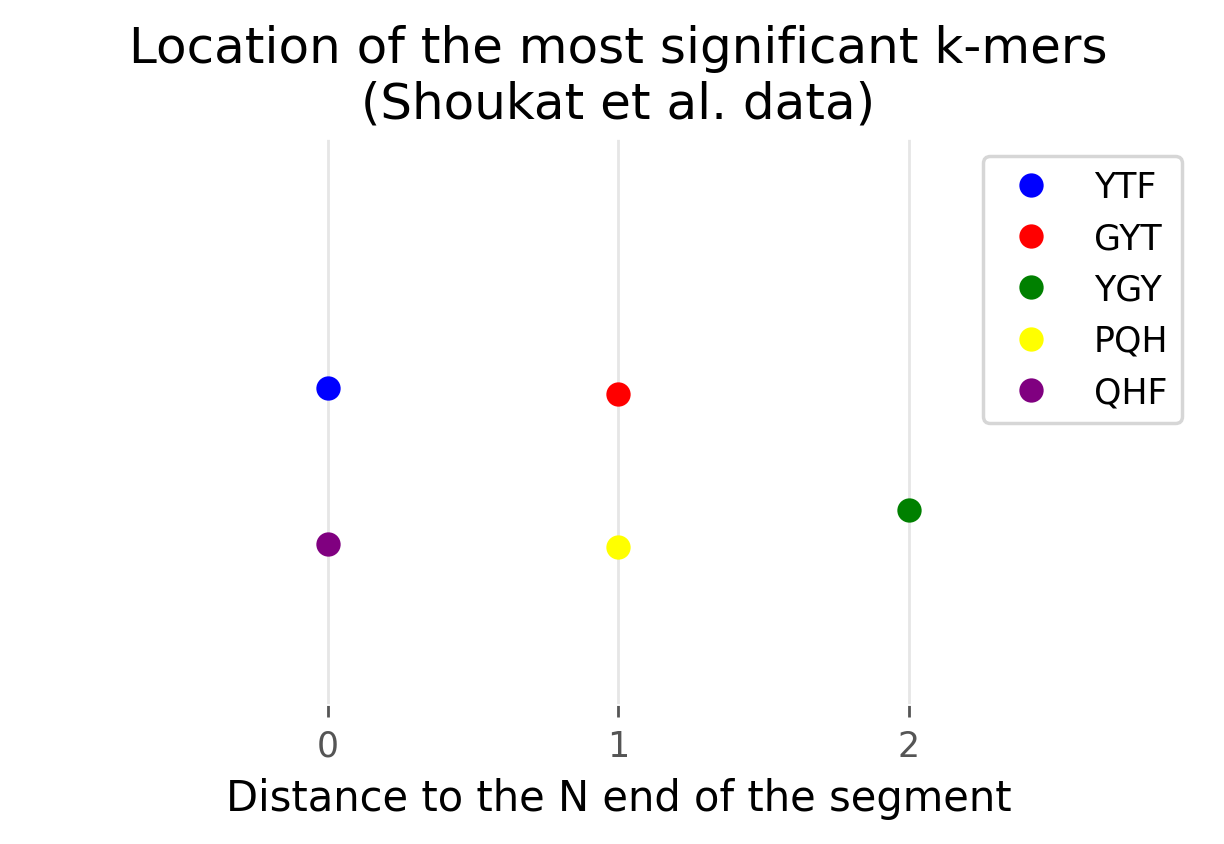

In [43]:
# title = 'Образцы переболевших'
title = f'Location of the most significant k-mers\n({PAPER} data)'

plt.figure(figsize=(6, 3), dpi=250)
colors = ['blue', 'red', 'green', 'yellow', 'purple']
for c, (k, values) in zip(colors, positions.items()):
    plt.plot(values, 'ro', color=c, label=k)
plt.legend()
plt.xlabel('Distance to the N end of the segment')
plt.title(title)
plt.xticks([0, 1, 2])
plt.yticks([0])
plt.xlim(-1, 3)
plt.ylim(0.1, 2);

conv


/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


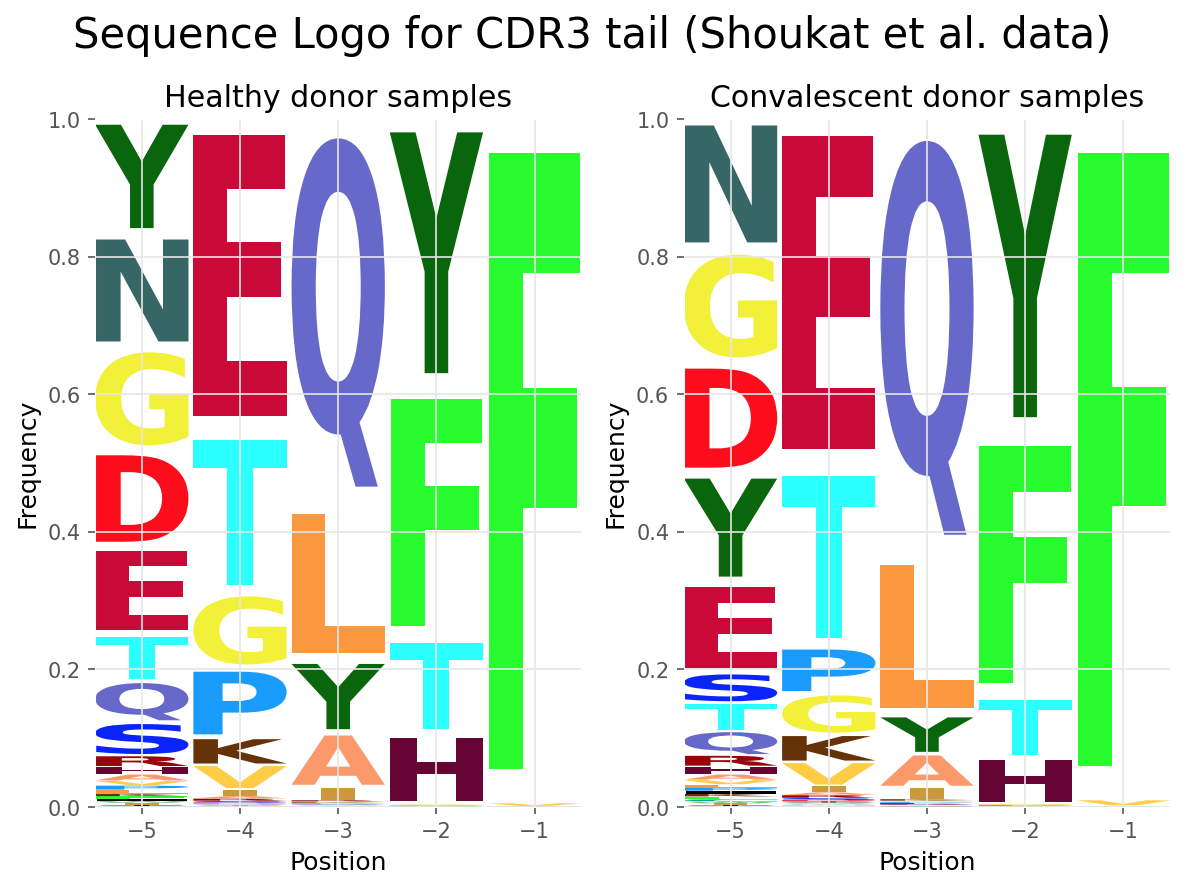

In [25]:
def aa_freqs(folder):
    res = {
        i: defaultdict(int) for i in range(-5, 0) 
    }

    for filename in os.listdir(folder):

        df = reformat_table(pd.read_csv(folder + filename, sep='\t'))
        df = normalize_v_usage(df)
        
        for i, row in df.iterrows():
            seq = row['aaSeqCDR3']

            for i in range(-5, 0):
                try:
                    res[i][seq[i]] += row['freq']
                except IndexError:
                    pass
                
    res = pd.DataFrame(res).fillna(0).transpose()
    res = res.div(res.sum(axis=1), axis=0)
    return res # pd.DataFrame(res).fillna(0).transpose()

folder_healthy = 'use_of_ml_paper_data/healthy/'
folder_conv = 'use_of_ml_paper_data/patient/'
   
healthy = aa_freqs(folder_healthy)
print('conv')
conv = aa_freqs(folder_conv)
    
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(8, 6))
logo_h = logomaker.Logo(healthy, color_scheme='skylign_protein',
              vpad=0.1, ax=axs[0])

logo_c = logomaker.Logo(conv, color_scheme='skylign_protein',
              vpad=0.1, ax=axs[1])

# logo.ax.set_xlabel('Позиция')

for ax in axs:
    ax.set_xlabel('Position')
    ax.set_ylabel('Frequency')
axs[0].set_title('Healthy donor samples');
axs[1].set_title('Convalescent donor samples')

fig.suptitle(f'Sequence Logo for CDR3 tail ({PAPER} data)', fontsize=20)
fig.tight_layout()

### Train model on statistically significant k-mers

In [6]:
ssk = ['YTF', 'GYT', 'YGY']

def get_ssk_data(key='all', log=False, kmers=['YTF', 'GYT', 'YGY']):
    if key == 'all':
        X = all_data[kmers]
        y = all_data['label']
        source = all_data['source']
    elif key == 'our':
        X = our_data[kmers]
        y = our_data['label']
    else:
        X = paper_data[kmers]
        y = paper_data['label']
    
    if log:
        X = np.log(X)
    
    if key == 'all':
        return X, y, source
    else:
        return X, y

In [7]:
# X = np.log(all_data[ssk])
# X = all_data[ssk]
# y = all_data['label']

#  X, y, source = get_ssk_data('all', )
X, y = get_ssk_data('paper')
# X, y = get_ssk_data('our', ) #  kmers=our_ssk['noadj'])

In [32]:
np.random.seed(28)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=None)
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [136]:
X_normalized = X.copy()
for i, row in X.iterrows():
    s = row.sum()
    row = row / s
    X_normalized.loc[i, :] = row

<AxesSubplot:>

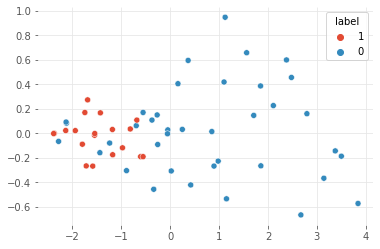

In [8]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
# X_scaled = sc.fit_transform(X_normalized)
X_pca = PCA(n_components=2).fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, hue_order=[1, 0])
# sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, )

## Statistically significant J-segments...

In [8]:
def find_ssj(df):
    total = 0
    results = []
    for kmer in tqdm(j_segment_labels):
        tmp = df.loc[df[kmer] != 0, :]
        number_of_non_zero = tmp.shape[0]
        if number_of_non_zero > 30:
            total += 1

            healthy = tmp.query('label == 0')[kmer]
            conv = tmp.query('label == 1')[kmer]

            t, p = sp.stats.shapiro(np.log(tmp[kmer]))
            if p > 0.05:
                _, p = sp.stats.ttest_ind(healthy, conv)
            else:
                _, p = sp.stats.kruskal(healthy, conv)
            results.append([kmer, p])

    ssk_bonferroni = [] 
    ssk_noadj = []
    for i, (kmer, p) in enumerate(results):
        if p < ALPHA:
            ssk_noadj.append((kmer, p))
        if p < ALPHA / total:
            ssk_bonferroni.append((kmer, p))
    res = {
        'noadj': ssk_noadj,
        'bonf': ssk_bonferroni
    }
    return res

paper_j = find_ssj(paper_data)

100%|██████████| 13/13 [00:02<00:00,  4.97it/s]


In [9]:
paper_j

{'noadj': [('TRBJ2-7', 0.0037951640669938638),
  ('TRBJ2-1', 0.005499714776195487),
  ('TRBJ1-1', 0.0011110738885683335),
  ('TRBJ1-6', 0.030727242849818166),
  ('TRBJ1-5', 1.845050924497799e-05),
  ('TRBJ1-2', 5.055339862822204e-07),
  ('TRBJ2-3', 0.0023109413086344964)],
 'bonf': [('TRBJ2-7', 0.0037951640669938638),
  ('TRBJ1-1', 0.0011110738885683335),
  ('TRBJ1-5', 1.845050924497799e-05),
  ('TRBJ1-2', 5.055339862822204e-07),
  ('TRBJ2-3', 0.0023109413086344964)]}

In [11]:
j_segment_labels

['TRBJ2-7',
 'TRBJ2-1',
 'TRBJ1-1',
 'TRBJ2-2',
 'TRBJ1-6',
 'TRBJ1-5',
 'TRBJ2-5',
 'TRBJ1-2',
 'TRBJ2-3',
 'TRBJ2-6',
 'TRBJ1-3',
 'TRBJ1-4',
 'TRBJ2-4']